## Bluebike Forecasting

Time series forecasting can broadly be categorized into the following categories:
- Classical / Statistical Models — Auto Regression, Moving Averages, Exponential smoothing, ARIMA, SARIMA, TBATS
- Machine Learning — XGBoost, Random Forest, or any ML model with reduction methods
- Deep Learning — RNN, LSTM<br>
Here we will explore **Moving Averages**

Calculating a moving average involves creating a new series where the values are comprised of the average of raw observations in the original time series.

A moving average requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.
We have two types of moving averages

**Centered Moving Average**

$center_ma(t) = mean(obs(t-1), obs(t), obs(t+1))$

**Trailing Moving Average**

$trail_ma(t) = mean(obs(t-2), obs(t-1), obs(t))$

**Weighted Moving Averages**

We will use trailing Moving average.





In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

In [3]:
# Loading the data (All trip data)
trip_data = pd.read_pickle("/content/drive/MyDrive/blue_bikes_sales_prediction/data/raw_data.pkl")

In [4]:
trip_data.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,350,2017-01-01 00:06:58,2017-01-01 00:12:49,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,139,Dana Park,42.36178,-71.1081,644,Subscriber,NaN


In [32]:
# preprocessing
def get_groupby(data,condition):
  '''
  Etract day, month, hour from timestamp
  grouping by condition = 'hour' or 'date','year'

  '''
  df = data.copy()
  
  # extracting the yesr,date,hour from time stamp
  df['year'] = df.starttime.dt.year
  df['month'] = df.starttime.dt.month
  df['date'] = df.starttime.dt.date
  df['hour'] = df.starttime.dt.hour

  if condition == 'year':
    df = df.groupby(['year']).size().reset_index(name = 'Totalrides')
  if condition == 'month':
    df = df.groupby(['year','month']).size().reset_index(name = 'Totalrides')
  if condition == 'date':
    df = df.groupby(['year','month','date']).size().reset_index(name = 'Totalrides')
    df['date'] = pd.to_datetime(df.date)
  if condition == 'hour':
    df = df.groupby(['year','month','date','hour']).size().reset_index(name = 'Totalrides')    
  return df

In [33]:
df = get_groupby(trip_data,'date')
df.head(3)

,year,month,date,Totalrides
0,2017,1,2017-01-01,481
1,2017,1,2017-01-02,802
2,2017,1,2017-01-03,651


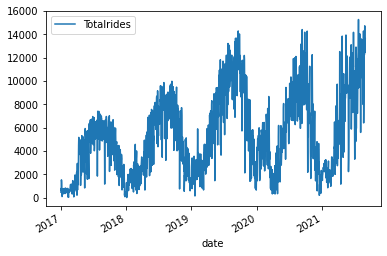

In [34]:
df = df[['date','Totalrides']]

df.plot(x = 'date')
plt.show()


Text(0.5, 1.0, 'Rolling Mean plot with window = 30')

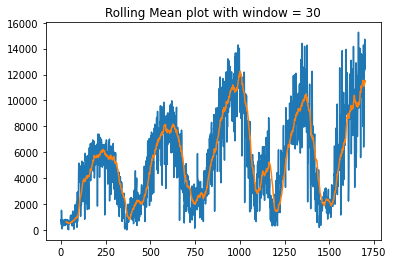

In [54]:
# Calculating Tail-rolling average transform
series = df.Totalrides
rolling = series.rolling(window=30)
rolling_mean = rolling.mean()
#print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot()
plt.title("Rolling Mean plot with window = 30")


Text(0.5, 1.0, 'Rolling Mean plot with window = 3')

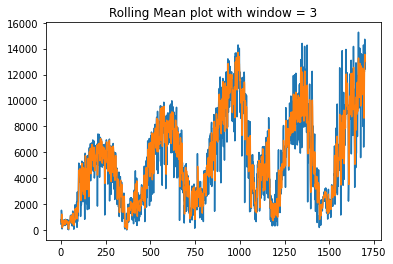

In [47]:
# Tail-rolling average transform
series = df.Totalrides
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
#print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot(x = 'date')
rolling_mean.plot()
plt.title("Rolling Mean plot with window = 3")

In [69]:
history = [X[i] for i in range(window)]
history

[481, 802, 651]

Test MSE: 2636938.451
Test R2: 0.777
Test MAE: 1204.538


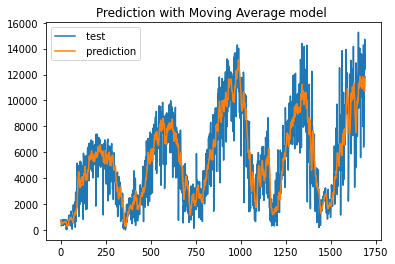

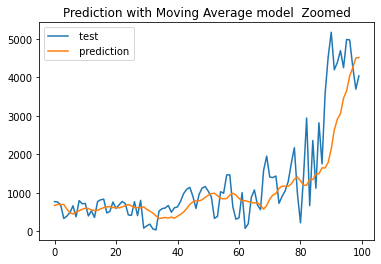

In [79]:
# prepare situation
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
X = df.Totalrides.values
window = 10
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = np.mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rsquared = r2_score(test, predictions)
mae = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test R2: %.3f' % rsquared)
print('Test MAE: %.3f' % mae)
# plot
plt.plot(test,label = " test")
plt.plot(predictions,label = " prediction")
plt.title( "Prediction with Moving Average model ")
plt.legend()
plt.show()
# zoom plot
plt.plot(test[0:100],label = " test")
plt.plot(predictions[0:100],label = " prediction")
plt.legend()
plt.title( "Prediction with Moving Average model  Zoomed")
plt.show()

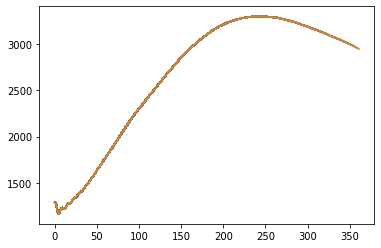

In [80]:
X = df.Totalrides.values
mse_error = []
r2_error = []
mae_error = []
for val in range(3,365):
  window = val
  history = [X[i] for i in range(window)]
  test = [X[i] for i in range(window, len(X))]
  predictions = list()
  # walk forward over time steps in test
  for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
  mse = mean_squared_error(test, predictions)
  r2 = r2_score(test, predictions)
  mae = mean_absolute_error(test, predictions)
  mse_error.append(mse)
  r2_error.append(r2)
  mae_error.append(mae)

  # print('Test MSE: %.3f' % error)
  # print('Test R2: %.3f' % r2)
  # print('Test MAE: %.3f' % mae)
 

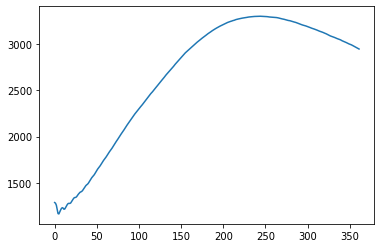

In [85]:
plt.plot(mae_error)

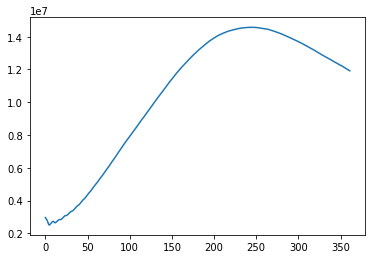

In [86]:
plt.plot(mse_error)

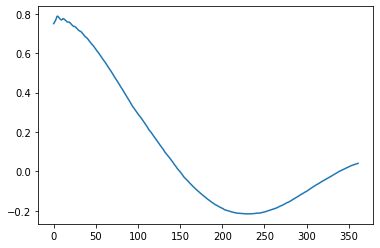

In [87]:
'''
The most common interpretation of r-squared 
is how well the regression model fits the observed data. 
For example, an r-squared of 60% reveals that 60% of the data
 fit the regression model. Generally, a higher r-squared indicates a better fit for the model.'''
plt.plot(r2_error)

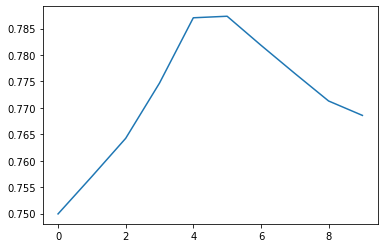

In [88]:
plt.plot(r2_error[0:10])

Test MSE: 2878716.249
Test R2: 0.757
Test MAE: 1278.965


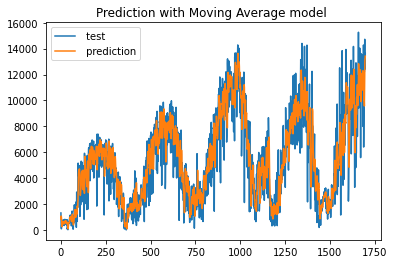

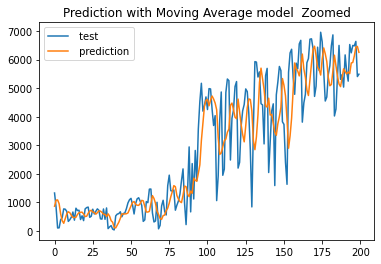

In [94]:
## We see window size of 4 is the optimal size
# prepare situation
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
X = df.Totalrides.values
window = 4
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = np.mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rsquared = r2_score(test, predictions)
mae = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test R2: %.3f' % rsquared)
print('Test MAE: %.3f' % mae)
# plot
plt.plot(test,label = " test")
plt.plot(predictions,label = " prediction")
plt.title( "Prediction with Moving Average model ")
plt.legend()
plt.show()
# zoom plot
plt.plot(test[0:200],label = " test")
plt.plot(predictions[0:200],label = " prediction")
plt.legend()
plt.title( "Prediction with Moving Average model  Zoomed")
plt.show()